### Hemibrain Dendrites Vs Axon Analysis
This code is a modified and generalized version of the R code `tangential_to_hdelta.R`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sqlite3
import re
from pathlib import Path

### Parameter Setup

In [2]:

cellType_pre = 'FB' 
cellType_post = 'hDelta' 

# For data visualization and refinement
cellName_pre = None
cellName_post = 'hDeltaB' 
groupBy_post = 'post'
groupBy_pre = 'pre_cell_type' # 'pre' or 'post' for specific instance, 'pre_cell_type' or 'post_cell_type' for type only 

figureSize = (19, 12)
fontSize_axis = 12
connTextSize = 8
xLabel = 'Pre Cell Type'
yLabel = 'hDeltaB ID'


### Load Connectivity data

In [3]:
# Data source paths
hemibrain_sql = r"\\research.files.med.harvard.edu\neurobio\wilsonlab\banc\connectivity\hemibrain_v.1.2.1_data.sqlite"

# Connect to the SQLite database
conn = sqlite3.connect(hemibrain_sql)

# List all tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", [table[0] for table in tables])

Tables in the database: ['edgelist', 'meta', 'synapses']


### Function Block

In [5]:
# Helper function to get the mode (most frequent value) of a series
def get_mode(x):
    return x.value_counts().index[0]

# Function to create pivot tables with consistent columns
def create_pivot_tables(data, groupBy_pre, groupBy_post):
    # Pivot the data to create a matrix of counts
    pivot_count = data.pivot_table(
        index=groupBy_post, 
        columns=groupBy_pre, 
        values='count', 
        aggfunc='sum', 
        fill_value=0
    )
    
    # Reindex to include ALL pre_cell_types
    pivot_count = pivot_count.reindex(
        columns=all_pre_cell_types, 
        index=all_post_cell_types, 
        fill_value=0
    )
    
    return pivot_count

def create_heatmap_subplot(ax, count_matrix, title, cmap_colors, xLabel, yLabel, fontSize_axis, connTextSize):
        """
        Create a heatmap subplot with custom coloring
        """
        # Prepare the data
        data = count_matrix.values
        masked_data = np.ma.array(data, mask=(data == 0))
        
        # Create the base heatmap
        im = ax.imshow(
            masked_data, 
            cmap='binary',  # Base colormap for zero values
            interpolation='nearest'
        )
        
        # Create custom colormap
        custom_cmap = mcolors.LinearSegmentedColormap.from_list(
            'custom_color', 
            cmap_colors,  # From light to dark
            N=256
        )
        
        # Overlay connection type specific colors
        for (i, j), count in np.ndenumerate(data):
            if count > 0:
                # Normalize count for color intensity
                norm = mcolors.Normalize(vmin=1, vmax=data.max())
                color = custom_cmap(norm(count))
                
                ax.add_patch(plt.Rectangle(
                    (j-0.5, i-0.5), 1, 1, 
                    facecolor=color, 
                    edgecolor='white', 
                    linewidth=1
                ))
                
                # Annotate with count
                ax.text(j, i, f'{count}', 
                        ha='center', va='center', 
                        fontsize=connTextSize,
                        color='black' if count < data.max()/2 else 'white')
        
        # Set up the plot
        ax.set_title(title, fontsize=fontSize_axis)
        ax.set_xlabel(xLabel, fontsize=fontSize_axis)
        ax.set_ylabel(yLabel, fontsize=fontSize_axis)
        
        # Set ticks
        ax.set_xticks(range(len(count_matrix.columns)))
        ax.set_xticklabels(count_matrix.columns, rotation=90, ha='center')
        ax.set_yticks(range(len(count_matrix.index)))
        ax.set_yticklabels(count_matrix.index)
        
        return im

# Create a custom color matrix
def create_custom_colormap():
    """
    Create custom diverging colormaps for axon-axon and axon-dendrite connections
    """
    # Soft green palette for axon-to-axon
    axon_to_axon_cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_green', 
        ['#f0f9e8', '#7fbf7b', '#1b7837'],  # Light to dark green
        N=256
    )
    
    # Soft red palette for axon-to-dendrite
    axon_to_dendrite_cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_red', 
        ['#fff5f0', '#fc9272', '#de2d26'],  # Light to dark red
        N=256
    )
    
    return {
        'axon to axon': axon_to_axon_cmap,
        'axon to dendrite': axon_to_dendrite_cmap
    }



### Run the pipeline and generate the dendrite vs axon heatmap

C:\Users\Wilson_Lab\AppData\Local\Temp\ipykernel_33804\2536056279.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('top_p', ascending=False))


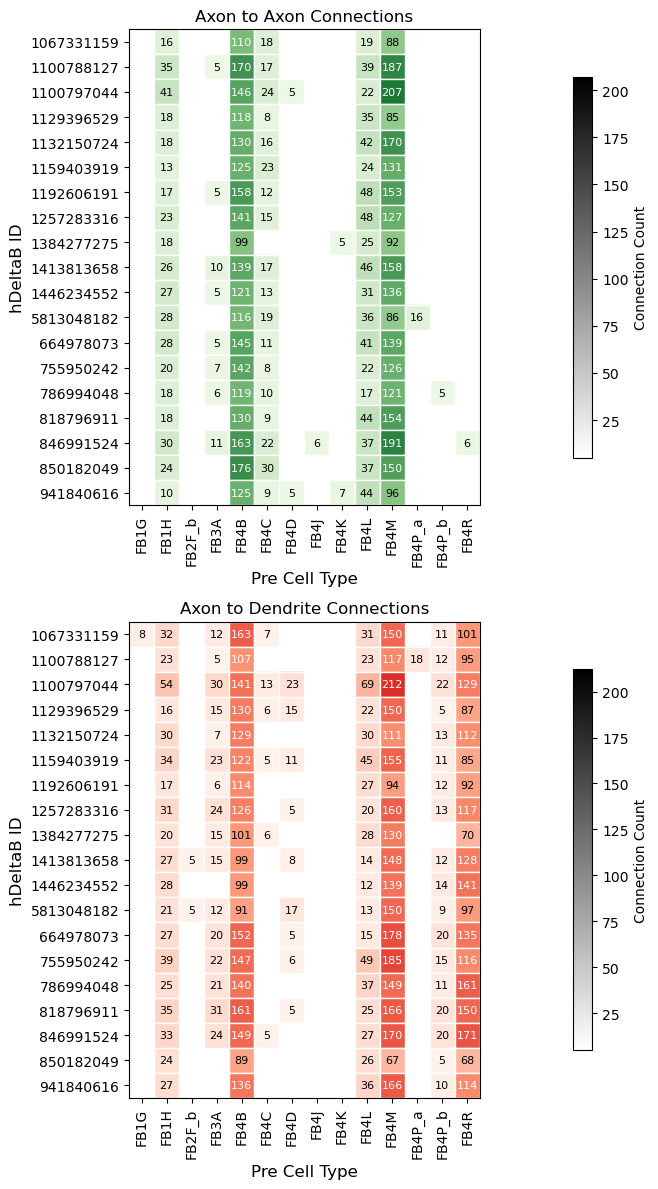

In [14]:
# Retrieve and process metadata
hb_meta = pd.read_sql_query("SELECT * FROM meta", conn)
hb_meta = (hb_meta.groupby('type')
           .apply(lambda x: x.sort_values('top_p', ascending=False))
           .reset_index(drop=True)
           .rename(columns={'type': 'cell_type'}))
hb_meta['top_nt'] = hb_meta.groupby('cell_type')['top_nt'].transform(get_mode)

# Filter for 2 different celltypes
hb_cellType_pre = hb_meta[hb_meta['cell_type'].str.startswith(cellType_pre)] # Presynaptic
hb_cellType_post = hb_meta[hb_meta['cell_type'].str.startswith(cellType_post)] # Postsynaptic

# Collect IDs for both
cellType_pre_ids = hb_cellType_pre['bodyid'].tolist()
cellType_post_ids = hb_cellType_post['bodyid'].tolist()

# Construct and execute SQL query to retrieve relevant connections
query = f"""
SELECT *
FROM edgelist
WHERE count >= 5
  AND pre IN ({','.join(map(str, cellType_pre_ids))})
  AND post IN ({','.join(map(str, cellType_post_ids))})
"""
hb_elist_th = pd.read_sql_query(query, conn)

# Merge edgelist with metadata and filter connections
hb_elist_merged = (hb_elist_th.drop(columns=['pre_top_nt', 'post_top_nt'])
                   .merge(hb_meta[['bodyid', 'cell_type', 'top_nt']], left_on='pre', right_on='bodyid', 
                          suffixes=('', '_pre'))
                   .merge(hb_meta[['bodyid', 'cell_type', 'top_nt']], left_on='post', right_on='bodyid', 
                          suffixes=('_pre', '_post'))
                   .rename(columns={'cell_type_pre': 'pre_cell_type', 'cell_type_post': 'post_cell_type',
                                    'top_nt_pre': 'pre_top_nt', 'top_nt_post': 'post_top_nt'})
                   .query("post_label in ['axon', 'dendrite'] and pre_label in ['axon', 'dendrite']"))

# Reshape and collapse data by cell type
if cellName_pre:
    hb_elist_collapsed = (hb_elist_merged.query(f"pre_cell_type == '{cellName_pre}'")
                      .assign(connection_type=lambda x: x['pre_label'] + ' to ' + x['post_label'])
                      .groupby([groupBy_pre, groupBy_post, 'connection_type'])
                      .agg({'count': 'sum', 'pre_top_nt': 'first', 'post_top_nt': 'first'})
                      .reset_index()
                      .sort_values('count', ascending=False))
elif cellName_post: 
    hb_elist_collapsed = (hb_elist_merged.query(f"post_cell_type == '{cellName_post}'")
                          .assign(connection_type=lambda x: x['pre_label'] + ' to ' + x['post_label'])
                          .groupby([groupBy_pre, groupBy_post, 'connection_type'])
                          .agg({'count': 'sum', 'pre_top_nt': 'first', 'post_top_nt': 'first'})
                          .reset_index()
                          .sort_values('count', ascending=False))
else:
    hb_elist_collapsed = (hb_elist_merged.assign(connection_type=lambda x: x['pre_label'] + ' to ' + x['post_label'])
                          .groupby([groupBy_pre, groupBy_post, 'connection_type'])
                          .agg({'count': 'sum', 'pre_top_nt': 'first', 'post_top_nt': 'first'})
                          .reset_index()
                          .sort_values('count', ascending=False))

# Data Visualization
# Prepare data for heatmap
aggregated_data = (hb_elist_collapsed[hb_elist_collapsed['connection_type'].isin(['axon to dendrite', 'axon to axon'])]
                   .groupby([groupBy_pre, groupBy_post, 'connection_type'])
                   .agg({'count': 'sum'})
                   .reset_index())

# Get the full set of unique pre_cell_types from the entire dataset
all_pre_cell_types = aggregated_data[groupBy_pre].unique()
all_post_cell_types = aggregated_data[groupBy_post].unique()

# Split dataframes by connection type
axon_to_axon_data = aggregated_data[aggregated_data['connection_type'] == 'axon to axon']
axon_to_dendrite_data = aggregated_data[aggregated_data['connection_type'] == 'axon to dendrite']


# Create pivot tables with shared columns
axon_to_axon_count = create_pivot_tables(axon_to_axon_data, groupBy_pre, groupBy_post)
axon_to_dendrite_count = create_pivot_tables(axon_to_dendrite_data, groupBy_pre, groupBy_post)

# Set up the matplotlib figure
plt.figure(figsize=figureSize)

# Create subplots
# Axon to Axon (Green palette)
ax1 = plt.subplot(2, 1, 1)
im1 = create_heatmap_subplot(
    ax1, 
    axon_to_axon_count, 
    'Axon to Axon Connections', 
    ['#f0f9e8', '#7fbf7b', '#1b7837'],
    xLabel, yLabel, fontSize_axis,connTextSize
)
plt.colorbar(im1, ax=ax1, label='Connection Count', shrink=0.8)

# Axon to Dendrite (Red palette)
ax2 = plt.subplot(2, 1, 2)
im2 = create_heatmap_subplot(
    ax2, 
    axon_to_dendrite_count, 
    'Axon to Dendrite Connections', 
    ['#fff5f0', '#fc9272', '#de2d26'],
    xLabel, yLabel, fontSize_axis,connTextSize
)
plt.colorbar(im2, ax=ax2, label='Connection Count', shrink=0.8)

plt.tight_layout()
